In [1]:
file_id_train = "17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT" #links = 2 (472827)events
file_id_val = "1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg" #links = 1 (920599)events

#!gdown https://drive.google.com/uc?id={file_id_train}
#!gdown https://drive.google.com/uc?id={file_id_val}
!ls

!pip install nflows
!pip install nvitop

figures  Originale.ipynb  README.md
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.base import MultiscaleCompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from torch import optim
from sklearn import preprocessing
import scipy.special

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import gc

In [5]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [6]:
x = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset.txt", delimiter=',')
L=len(x)
print(L)

472827


In [7]:
x = x[:int(L/16),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

xtr = np.copy(x)
xtrval = np.copy(xval)

#we shift so as to avoid applying the logarithm to numbers in (0,1), log per smussare i picchi
xtr = np.log(10 + x)
#standardization of the dataset
scaler = preprocessing.StandardScaler().fit(xtr)
xtr = scaler.transform(xtr)


xtrval = np.log(10 + xval)
scaler = preprocessing.StandardScaler().fit(xtrval)
xtrval = scaler.transform(xtrval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 29551
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



/home/unipi/i.ditota/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


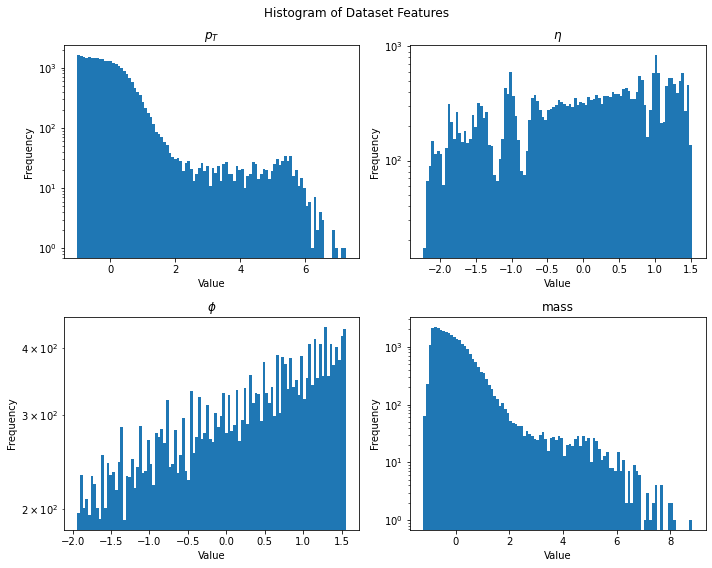

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Dataset Features")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)


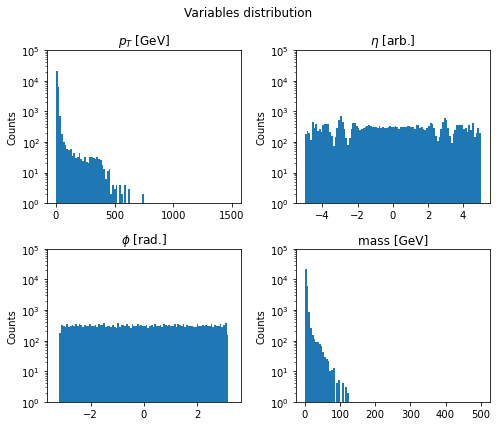

In [9]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

In [10]:
num_iterations = 4
num_features=4 #just for testing

base_dist = StandardNormal(shape=[num_features])

transforms = []
for _ in range(num_iterations):
  transforms.append(ReversePermutation(features=num_features))
  transforms.append(MaskedAffineAutoregressiveTransform(features=num_features,hidden_features=128))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
tp = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(tp)
optimizer = optim.Adam(flow.parameters())

flow = flow.to('cuda')


270880


50 tensor(3.1923, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(3.0628, device='cuda:0', grad_fn=<NegBackward0>)


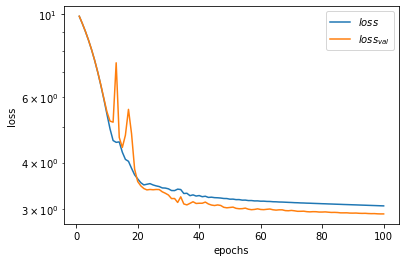

In [11]:
num_iter = 100

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(num_iter):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, num_iter+1), loss_values, label='$loss$')
plt.plot(range(1, num_iter+1), loss_validation,label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [12]:
sample = flow.sample(int(len(x)))
print(sample.shape)
sample = sample.cpu()
sample = sample.detach().numpy()


torch.Size([29551, 4])


In [13]:
sample = scaler.inverse_transform(sample)
#sample = scipy.special.erf(sample)
sample = np.exp(sample) - 10


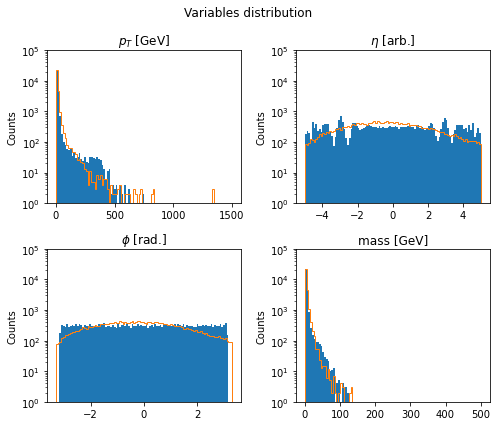

In [14]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].hist(sample[:,0],bins=n_bins, range=(0,1500),histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].hist(sample[:,3],bins=n_bins, range=(0,500),histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [15]:
#torch.cuda.empty_cache()
#gc.collect()
#next(flow.parameters()).is_cuda

In [16]:
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

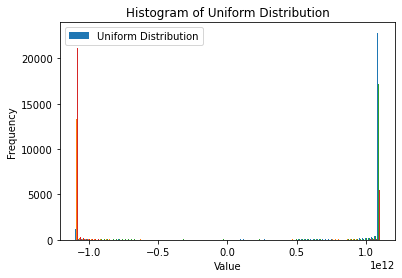

<Figure size 432x288 with 0 Axes>

In [28]:
###COMPRESSING###
N = 10

x_tensor = torch.tensor(x).to('cuda').float()
gaus = flow.transform_to_noise(x_tensor)
unif = torch.erf(gaus)
unif = unif * 2**N
unif = torch.floor(unif)

plt.hist(unif.cpu().detach().numpy(), bins=100, label='Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Uniform Distribution')
plt.legend()
plt.show()
plt.savefig('figures/unif.pdf', dpi=190)


comp = unif/2**N   #compression
gaus_comp = torch.erfinv(comp)
x_comp = flow.sample(len(gaus_comp))


x_comp = x_comp.cpu().detach().numpy()
x_comp = scaler.inverse_transform(x_comp)
x_comp = np.exp(x_comp) - 10



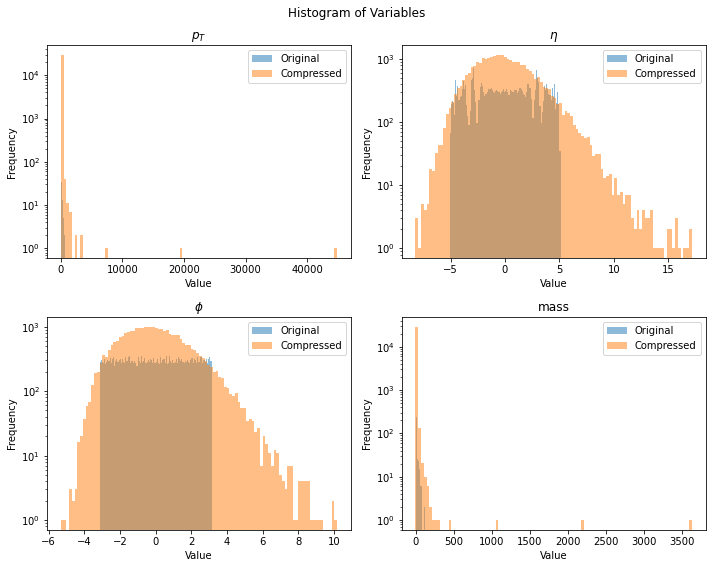

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Variables")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[0, 0].hist(x_comp[:, 0], bins=n_bins, label='Compressed', alpha=0.5)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[0, 1].hist(x_comp[:, 1], bins=n_bins, label='Compressed', alpha=0.5)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[1, 0].hist(x_comp[:, 2], bins=n_bins, label='Compressed', alpha=0.5)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[1, 1].hist(x_comp[:, 3], bins=n_bins, label='Compressed', alpha=0.5)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].legend()

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)
